# Modeling and Simulation in Python

Chapter 8: Pharmacokinetics

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [73]:
# If you want the figures to appear in the notebook, 
# and you want to interact with them, use
# %matplotlib notebook

# If you want the figures to appear in the notebook, 
# and you don't want to interact with them, use
# %matplotlib inline

# If you want the figures to appear in separate windows, use
# %matplotlib qt5

# tempo switch from one to another, you have to select Kernel->Restart

%matplotlib inline

from modsim import *

### Data

We have data from Pacini and Bergman (1986), "MINMOD: a computer program to calculate insulin sensitivity and pancreatic responsivity from the frequently sampled intravenous glucose tolerance test", *Computer Methods and Programs in Biomedicine*, 23: 113-122..

In [74]:
data = pd.read_csv('glucose_insulin.csv', index_col='time')
data

,glucose,insulin
time,,
0,92,11
2,350,26
4,287,130
6,251,85
8,240,51
10,216,49
12,211,45
14,205,41
16,196,35


Here's what the glucose time series looks like.

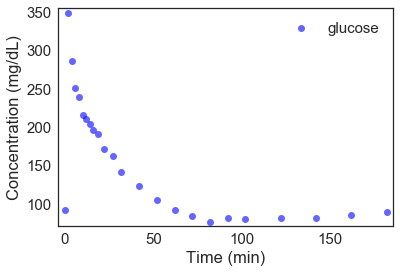

In [75]:
plot(data.glucose, 'bo', label='glucose')
decorate(xlabel='Time (min)',
         ylabel='Concentration (mg/dL)')

And the insulin time series.

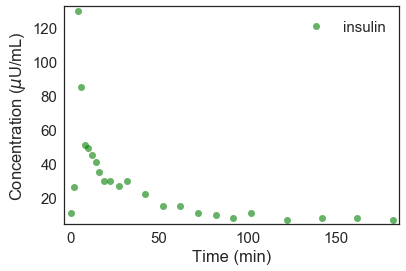

In [76]:
plot(data.insulin, 'go', label='insulin')
decorate(xlabel='Time (min)',
         ylabel='Concentration ($\mu$U/mL)')

For the book, I put them in a single figure, using `subplot`

Saving figure to file chap08-fig01.pdf


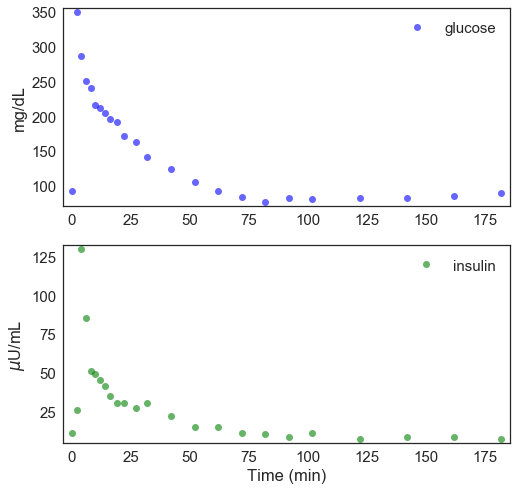

In [77]:
subplot(2, 1, 1)
plot(data.glucose, 'bo', label='glucose')
decorate(ylabel='mg/dL')

subplot(2, 1, 2)
plot(data.insulin, 'go', label='insulin')
decorate(xlabel='Time (min)',
         ylabel='$\mu$U/mL')

savefig('chap08-fig01.pdf')

### Interpolation

We have measurements of insulin concentration at discrete points in time, but we need to estimate it at intervening points.  We'll use `interpolate`, which is a wrapper for `scipy.interpolate.interp1d`

In [78]:
%psource interpolate

The return value from `interpolate` is a function.

In [79]:
I = interpolate(data.insulin, kind="cubic")

We can use the result, `I`, to estimate the insulin level at any point in time.

In [80]:
I(7)

array(61.318215880671474)

`I` can also take an array of time and return an array of estimates, which we can plot.

Saving figure to file chap08-fig02.pdf


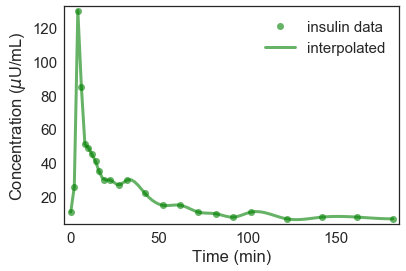

In [81]:
ts = linrange(0, 182, 2)

plot(data.insulin, 'go', label='insulin data')
plot(ts, I(ts), color='green', label='interpolated')

decorate(xlabel='Time (min)',
         ylabel='Concentration ($\mu$U/mL)')

savefig('chap08-fig02.pdf')

**Exercise:** [Read the documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html) of `scipy.interpolate.interp1d`.  Pass a keyword argument to `interpolate` to specify one of the other kinds of interpolation, and run the code again to see what it looks like. 

### The glucose minimal model

I'll cheat by starting with parameters that fit the data roughly; then we'll see how to improve them.

In [82]:
k1 = 0.03
k2 = 0.02
k3 = 1e-05
G0 = 290

To estimate basal levels, we'll use the concentrations at `t=0`.

In [83]:
Gb = data.glucose[0]
Ib = data.insulin[0]

In the initial conditions, `X(0)=0` and `G(0)=G0`, where `G0` is one of the parameters we'll choose.

In [84]:
init = State(G=G0, X=0)

Here's the system object with all parameters and the interpolation object `I`.

In [85]:
system = System(init=init, 
                k1=k1, k2=k2, k3=k3,
                I=I, Gb=Gb, Ib=Ib,
                t0=0, t_end=182, dt=0.5)

And here's the update function.  Using `unpack` to make the system variables accessible without using dot notation, which makes the translation of the differential equations more readable and checkable.

In [86]:
def update_func(state, t, system):
    """Updates the glucose minimal model.
    
    state: State object
    t: time in min
    system: System object
    
    returns: State object
    """
    G, X = state
    unpack(system)
        
    dGdt = -k1 * (G - Gb) - X*G
    dXdt = k3 * (I(t) - Ib) - k2 * X
    
    G += dGdt * dt
    X += dXdt * dt

    return State(G=G, X=X)

Before running the simulation, it is always a good idea to test the update function using the initial conditions.  In this case we can veryify that the results are at least qualitatively correct.

In [87]:
update_func(init, 0, system)

,value
G,287.03
X,0.00


Now run simulation is pretty much the same as it always is.

In [88]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
    
    Adds a TimeFrame to `system` as `results`
    
    system: System object
    update_func: function that updates state
    """
    unpack(system)
    
    frame = TimeFrame(columns=init.index)
    frame.loc[t0] = init
    ts = linrange(t0, t_end-dt, dt)
    
    for t in ts:
        frame.loc[t+dt] = update_func(frame.loc[t], t, system)
    
    system.results = frame

And here's how we run it.  `%time` is a Jupyter magic command that runs the function and reports its run time.

In [89]:
%time run_simulation(system, update_func)

Wall time: 585 ms


The results are in a `TimeFrame object` with one column per state variable.

In [90]:
system.results

,G,X
0.0,290.000000,0.000000
0.5,287.030000,0.000000
1.0,284.104550,-0.000120
1.5,281.239970,-0.000247
2.0,278.436097,-0.000299
2.5,275.681178,-0.000221
3.0,272.956420,0.000014
3.5,270.240227,0.000403
4.0,267.512143,0.000919
4.5,264.756530,0.001505


The following plot shows the results of the simulation along with the actual glucose data.

Saving figure to file chap08-fig03.pdf


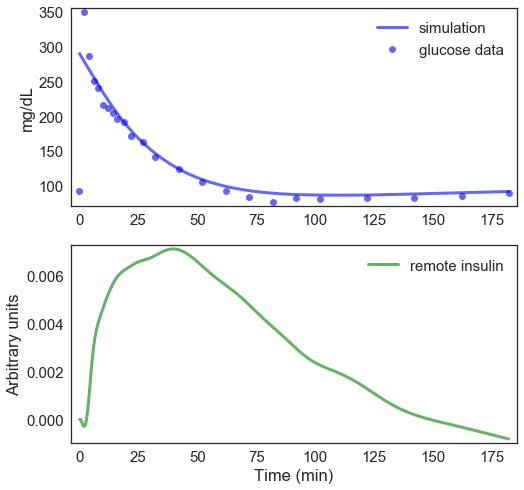

In [91]:
subplot(2, 1, 1)

plot(system.results.G, 'b-', label='simulation')
plot(data.glucose, style='bo', label='glucose data')
decorate(ylabel='mg/dL')

subplot(2, 1, 2)

plot(system.results.X, style='g-', label='remote insulin')

decorate(xlabel='Time (min)', 
         ylabel='Arbitrary units')

savefig('chap08-fig03.pdf')

### Numerical solution

We can do the same thing using `odeint`.  Instead of an update function, we provide a slope function that just evaluates the right-hand side of the differential equations.  We don't have to do the update part; `odeint` does it for us.

In [92]:
def slope_func(state, t, system):
    """Computes derivatives of the glucose minimal model.
    
    state: State object
    t: time in min
    system: System object
    
    returns: derivatives of G and X
    """
    G, X = state
    unpack(system)
    
    dGdt = -k1 * (G - Gb) - X*G
    dXdt = k3 * (I(t) - Ib) - k2 * X
    
    return dGdt, dXdt

We can test the slope function with the initial conditions.

In [93]:
slope_func(init, 0, system)

(-5.9399999999999995, 0.0)

The `System` object we use with `run_odeint` is almost the same as the one we used with `run_simulation`, but instead of providing `t0`, `t_end`, and `dt`, we provide an array of times where we want to evaluate the solution.  In this case, we use `data.index`, so the results are evaluated at the same times as the measurements.

In [94]:
system2 = System(init=init, 
                k1=k1, k2=k2, k3=k3,
                I=I, Gb=Gb, Ib=Ib,
                ts=data.index)

`run_odeint` is a wrapper for `scipy.integrate.odeint`

In [95]:
%psource run_odeint

Here's how we run it.

In [96]:
%time run_odeint(system2, slope_func)

Wall time: 104 ms


And here are the results.

In [97]:
system2.results

,G,X
time,,
0,290.000000,0.000000
2,278.568396,-0.000286
4,267.557071,0.001190
6,256.173536,0.003187
8,244.815439,0.004090
10,233.878160,0.004677
12,223.419189,0.005206
14,213.466144,0.005629
16,204.044929,0.005939


Plotting the results from `run_simulation` and `run_odeint`, we can see that they are not very different.

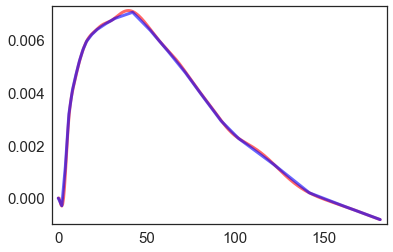

In [98]:
plot(system.results.X, 'r-')
plot(system2.results.X, 'b-')
#plot(data.glucose, 'bo')

The differences are usually less than 1% and always less than 2%.

In [99]:
diff = system.results - system2.results
percent_diff = diff / system2.results * 100
percent_diff.dropna()

,G,X
2.0,-0.047492,4.660530
4.0,-0.016792,-22.736831
6.0,0.048674,-4.639760
8.0,0.052622,-1.188321
10.0,0.035382,-0.810583
12.0,0.014674,-0.467651
14.0,-0.011426,-0.202991
16.0,-0.042508,0.088482
19.0,-0.097076,0.303891
22.0,-0.151211,0.292947


**Exercise:** What happens to these errors if you run the simulation with a smaller value of `dt`?

### Optimization

Now let's find the parameters that yield the best fit for the data.

In [100]:
k1 = 0.03
k2 = 0.02
k3 = 1e-05
G0 = 290

Again, we'll get basal levels from the initial values.

In [101]:
Gb = data.glucose[0]
Ib = data.insulin[0]

And the slope function is the same.

In [102]:
def slope_func(state, t, system):
    """Computes derivatives of the glucose minimal model.
    
    state: State object
    t: time in min
    system: System object
    
    returns: derivatives of G and X
    """
    G, X = state
    unpack(system)
    
    dGdt = -k1 * (G - Gb) - X*G
    dXdt = k3 * (I(t) - Ib) - k2 * X
    
    return dGdt, dXdt

`make_system` takes the parameters and `DataFrame` and returns a `System` object.

In [103]:
def make_system(G0, k1, k2, k3, data):
    """Makes a System object with the given parameters.
    
    G0: initial blood glucose
    k1: rate parameter
    k2: rate parameter
    k3: rate parameter
    data: DataFrame
    
    returns: System object
    """
    init = State(G=G0, X=0)
    system = System(init=init, 
                    k1=k1, k2=k2, k3=k3,
                    Gb=Gb, Ib=Ib, 
                    I=interpolate(data.insulin),
                    ts=data.index)
    return system

`error_func` takes the parameters and actual data, makes a `System` object and runs it, then compares the results of the simulation to the data.  It returns an array of errors.

In [104]:
def error_func(params, data):
    """Computes an array of errors to be minimized.
    
    params: sequence of parameters
    data: DataFrame of values to be matched
    
    returns: array of errors
    """
    print(params)
    
    # make a System with the given parameters
    system = make_system(*params, data)
    
    # solve the ODE
    run_odeint(system, slope_func)
    
    # compute the difference between the model
    # results and actual data
    error = system.results.G - data.glucose
    return error.loc[8:]

When we call `error_func`, we provide a sequence of parameters as a single object.

In [105]:
params = G0, k1, k2, k3
params

(290, 0.03, 0.02, 1e-05)

Here's how that works:

In [106]:
error_func(params, data)

(290, 0.03, 0.02, 1e-05)


time
8       4.385049
10     17.385689
12     11.875391
14      7.883104
16      7.432604
19     -1.688894
22      6.430723
27     -1.858707
32      4.627308
42      0.272257
52      4.125928
62      7.310554
72      9.102455
82     12.434359
92      5.498085
102     5.712650
122     4.844866
142     6.356758
162     5.136930
182     1.795663
dtype: float64

`fit_leastsq` is a wrapper for `scipy.optimize.leastsq`

In [107]:
%psource fit_leastsq

Here's how we call it.

In [108]:
best_params = fit_leastsq(error_func, params, data)

[  2.90000000e+02   3.00000000e-02   2.00000000e-02   1.00000000e-05]
[  2.90000000e+02   3.00000000e-02   2.00000000e-02   1.00000000e-05]
[  2.90000000e+02   3.00000000e-02   2.00000000e-02   1.00000000e-05]
[  2.90000004e+02   3.00000000e-02   2.00000000e-02   1.00000000e-05]
[  2.90000000e+02   3.00000004e-02   2.00000000e-02   1.00000000e-05]
[  2.90000000e+02   3.00000000e-02   2.00000003e-02   1.00000000e-05]
[  2.90000000e+02   3.00000000e-02   2.00000000e-02   1.00000001e-05]
[  2.78224727e+02   2.85801825e-02   1.61589429e-02   1.19289840e-05]
[  2.78224731e+02   2.85801825e-02   1.61589429e-02   1.19289840e-05]
[  2.78224727e+02   2.85801829e-02   1.61589429e-02   1.19289840e-05]
[  2.78224727e+02   2.85801825e-02   1.61589432e-02   1.19289840e-05]
[  2.78224727e+02   2.85801825e-02   1.61589429e-02   1.19289842e-05]
[  2.71951893e+02   2.68943464e-02   1.28042303e-02   1.03928810e-05]
[  2.71951897e+02   2.68943464e-02   1.28042303e-02   1.03928810e-05]
[  2.71951893e+02   

Now that we have `best_params`, we can use it to make a `System` object and run it.

We have to use the scatter operator, `*`, to make `best_params` behave like four separate parameters, rather than a single object.

In [109]:
system = make_system(*best_params, data)
run_odeint(system, slope_func)

Here are the results, along with the data.  The first few points of the model don't fit the data, but we don't expect them to.

Saving figure to file chap08-fig04.pdf


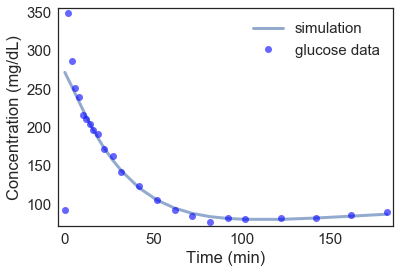

In [110]:
plot(system.results.G, label='simulation')
plot(data.glucose, style='bo', label='glucose data')

decorate(xlabel='Time (min)',
         ylabel='Concentration (mg/dL)')

savefig('chap08-fig04.pdf')

**Exercise:** Since we don't expect the first few points to agree, it's probably better not to make them part of the optimization process.  We can ignore them by leaving them out of the `Series` returned by `error_func`.  Modify the last line of `error_func` to return `errors.loc[8:]`, which includes only the elements of the `Series` from `t=8` and up.

Does that improve the quality of the fit?  Does it change the best parameters by much?

Note: You can read more about this use of `loc` [in the Pandas documentation](https://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-integer).

**Exercise:** How sensitive are the results to the starting guess for the parameters.  If you try different values for the starting guess, do we get the same values for the best parameters?

### Interpreting parameters

Based on the parameters of the model, we can estimate glucose effectiveness and insulin sensitivity.

In [111]:
def indices(G0, k1, k2, k3):
    """Compute glucose effectiveness and insulin sensitivity.
    
    G0: initial blood glucose
    k1: rate parameter
    k2: rate parameter
    k3: rate parameter
    data: DataFrame
    
    returns: State object containing S_G and S_I
    """
    return State(S_G=k1, S_I=k3/k2)

Here are the results.

In [112]:
indices(*best_params)

,value
S_G,0.026799
S_I,0.000881


### The insulin minimal model

In addition to the glucose minimal mode, Pacini and Bergman present an insulin minimal model, in which the concentration of insulin, $I$, is governed by this differential equation:

$ \frac{dI}{dt} = -k I(t) + \gamma (G(t) - G_T) t $

**Exercise:**  Write a version of `make_system` that takes the parameters of this model, `I0`, `k`, `gamma`, and `G_T` as parameters, along with a `DataFrame` containing the measurements, and returns a `System` object suitable for use with `run_simulation` or `run_odeint`.

Use it to make a `System` object with the following parameters:

In [145]:
I0 = 360
k = 0.25
gamma = 0.004
G_T = 80

In [114]:
def make_system(I0, k, gamma, G_T, data):
    init=State(I=I0)
    aah=System(init=init, i0=I0, k=k, gamma=gamma, G_T=G_T, data=data, G=interpolate(data.glucose), Gb=Gb, Ib=Ib, 
                    I=interpolate(data.insulin),
                    ts=data.index)
    return aah

In [115]:
system=make_system(I0,k,gamma,G_T,data)

**Exercise:** Write a slope function that takes state, t, system as parameters and returns the derivative of `I` with respect to time.  Test your function with the initial condition $I(0)=360$.

In [116]:
init=State(I=I0)

In [117]:
def slope_func(state, t, system):
    I = state
    unpack(system)
    
    dIdt = - k * I + gamma * (G(t) - G_T) * t
    
    return dIdt

In [118]:
slope_func(init, 0, system)

I   -90.0
dtype: float64

**Exercise:** Run `run_odeint` with your `System` object and slope function, and plot the results, along with the measured insulin levels.

In [119]:
run_odeint(system, slope_func)
system.results

,I
time,
0,360.000000
2,219.652719
4,137.739127
6,89.505898
8,61.636133
10,45.765330
12,37.053121
14,32.989732
16,31.406589


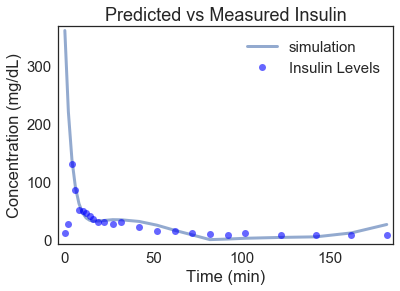

In [120]:
plot(system.results.I, label='simulation')
plot(data.insulin, style='bo', label='Insulin Levels')

decorate(xlabel='Time (min)',
         ylabel='Concentration (mg/dL)',
        title='Predicted vs Measured Insulin')

**Exercise:**  Write an error function that takes a sequence of parameters as an argument, along with the `DataFrame` containing the measurements.  It should make a `System` object with the given parameters, run it, and compute the difference between the results of the simulation and the measured values.  Test your error function by calling it with the parameters from the previous exercise.

Hint: As we did in a previous exercise, you might want to drop the errors for times prior to `t=8`.

In [121]:
def error_func(params, data):
    system=make_system(*params, data)
    run_odeint(system,slope_func)
    error = system.results.I - data.insulin
    return error.loc[8:]

In [122]:
params = [I0, k, gamma, G_T]

In [123]:
error_func(params, data)

time
8      10.636133
10     -3.234670
12     -7.946879
14     -8.010268
16     -3.593411
19      1.811071
22      2.581632
27      7.014287
32      3.758216
42      8.932902
52      9.554216
62      0.767804
72     -3.217947
82    -10.382598
92     -7.401702
102    -9.056569
122    -3.584244
142    -3.586427
162     3.170251
182    18.702699
dtype: float64

**Exercise:** Use `fit_leastsq` to find the parameters that best fit the data.  Make a `System` object with those parameters, run it, and plot the results along with the measurements.

In [124]:
fit_leastsq(error_func,params,data)

modsim.py: scipy.optimize.leastsq ran successfully
                 and returned the following message:
The relative error between two consecutive iterates is at most 0.000000


array([  3.45051065e+02,   2.48855798e-01,   3.83011719e-03,
         8.03295605e+01])

In [125]:
# Solution goes here

In [126]:

run_odeint(system, slope_func)

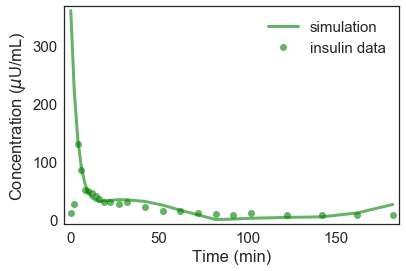

In [127]:

plot(system.results, 'g-', label='simulation')
plot(data.insulin, 'go', label='insulin data')

decorate(xlabel='Time (min)',
         ylabel='Concentration ($\mu$U/mL)')

**Exercise:** Using the best parameters, estimate the sensitivity to glucose of the first and second phase pancreatic responsivity:

$ \phi_1 = \frac{I_{max} - I_b}{k (G_0 - G_b)} $

$ \phi_2 = \gamma \times 10^4 $

In [139]:
I_max=data.insulin.max()
Ib=data.insulin[0]
#k=???
G0=G0
Gb=data.glucose[0]

In [141]:
num=(I_max-Ib)

In [148]:
denom=(k*(G0-Gb))

In [149]:
phi1=num/denom

In [150]:
phi2=gamma*1e4

In [151]:
phi1,phi2

(2.404040404040404, 40.0)